## Exploratory Data Analysis G2Net Gravitational Wave Detection 2021

This notebook covers basic EDA for the G2Net Gravitational Wave Detection competition. Also included: spectrogram and power spectral density (PSD) transformations and their visualizations using [GWpy library](https://gwpy.github.io/docs/stable/). Brief definitions of important concepts are also provided. References such as notebooks or papers used are listed below.

**Contents**

* [1. Libraries](#section-1)
* [2. Count labels in training set](#section-2)
* [3. Import and visualize training data as time series](#section-3)
    - [3.1 Time series example, target=1](#subsection-3_1)
    - [3.2 Time series example, target=0](#subsection-3_2)
* [4. Represent training data as spectrograms](#section-4)
    - [4.1 Spectrogram example, target=1](#subsection-4_1)
    - [4.2 Spectrogram example, target=0](#subsection-4_2)
* [5. Represent data as power spectral density (PSD)](#section-5)
    - [5.1 PSD example, target=1](#subsection-5_1)
    - [5.2 PSD example, target=0](#subsection-5_2)




**References**

Notebooks: 

(1) [ [EDA] G2Net GW Detection by Mukharbek Organokov ](https://www.kaggle.com/muhakabartay/eda-g2net-gw-detection).

(2) [G2Net Keras baseline [Training] by Ammar Alhaj Ali](https://www.kaggle.com/ammarnassanalhajali/g2net-keras-baseline-training).

Papers:

[1] [Bailes et al. *Gravitational-wave physics and astronomy in the 2020s and 2030s*, Nature (2021) ](https://www.nature.com/articles/s42254-021-00303-8).

Libraries:

{1} [*GWpy*: Duncan Macleod, Alex L. Urban, Scott Coughlin, Thomas Massinger, Matt Pitkin, rngeorge, … The Gitter Badger. (2021, April 27). gwpy/gwpy: 2.0.4 (Version v2.0.4). Zenodo. http://doi.org/10.5281/zenodo.472331](https://gwpy.github.io/docs/stable/).

<a id="section-1"></a>
## 1. Libraries 

First we install [GWpy](https://gwpy.github.io/docs/latest/index.html) which "is a collaboration-driven Python package providing tools for studying data from ground-based gravitational-wave detectors" and then load other libraries.

In [1]:
!python -m pip install gwpy 

     |████████████████████████████████| 1.4 MB 403 kB/s 
     |████████████████████████████████| 52 kB 708 kB/s 
     |████████████████████████████████| 9.7 MB 6.5 MB/s 
     |████████████████████████████████| 746 kB 7.3 MB/s 
  Created wheel for ligo-segments: filename=ligo_segments-1.3.0-cp37-cp37m-linux_x86_64.whl size=92279 sha256=bf7f3031a4f6dd6b1f82c852698d9215c51328814208f52eedeb53ded6bc6960
  Stored in directory: /root/.cache/pip/wheels/b7/cc/08/d877a20dafb946a7cf821c6d1a2895f1e227a54cef891c14d8
Successfully built ligo-segments


In [2]:
import os
import random

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from gwpy.timeseries import TimeSeries, TimeSeriesDict
from gwpy.plot import Plot

<a id="section-2"></a>
## 2. Count labels in training set

In [3]:
PATH='../input/g2net-gravitational-wave-detection/'

def get_train_file_path(event_id):
    """From an event id returns the path to the corresponding file"""
    file="train/{}/{}/{}/{}.npy".format(event_id[0],event_id[1],event_id[2],event_id) 
    return file

train_labels = pd.read_csv(os.path.join(PATH,'training_labels.csv'))

train_labels['file_path'] = [get_train_file_path(event_id=event) for event in train_labels['id']] 

train_labels.head()

,id,target,file_path
0,00000e74ad,1,train/0/0/0/00000e74ad.npy
1,00001f4945,0,train/0/0/0/00001f4945.npy
2,0000661522,0,train/0/0/0/0000661522.npy
3,00007a006a,0,train/0/0/0/00007a006a.npy
4,0000a38978,1,train/0/0/0/0000a38978.npy


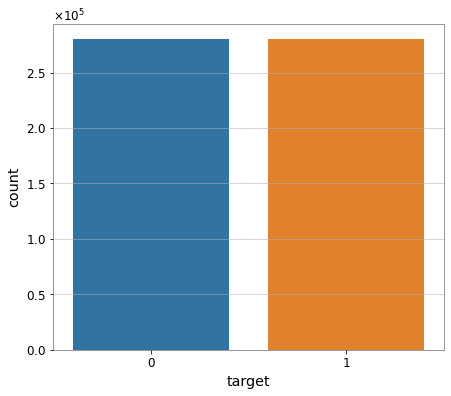

In [4]:
plt.figure(figsize=(7,6))
ax = sns.countplot( x = train_labels['target'] )


In [5]:
# get random event paths for target 0 and 1

def get_random_sample(df,value):
    "Gets a random event id with target=value=(0,1)"
    ids=df.loc[df['target'] == value]['id'].tolist()
    return random.sample(ids,1)[0]

# get a random sample with target = 1
event_1 = get_random_sample(df=train_labels,value=1)
path_1=train_labels.loc[train_labels['id'] == event_1]['file_path'].to_string(index=False,buf=None)
print('random_event(target=1): ', event_1)
print(path_1, '\n')

# get a random sample with target = 0
event_0 = get_random_sample(df=train_labels,value=0)
path_0=train_labels.loc[train_labels['id'] == event_0]['file_path'].to_string(index=False)
print('random_event(target=0): ', event_0)
print(path_0, '\n')



random_event(target=1):  4044a9050c
train/4/0/4/4044a9050c.npy 

random_event(target=0):  e263e86fca
train/e/2/6/e263e86fca.npy 



<a id="section-3"></a>
## 3. Import and visualize training data as time series

From the data description: "Each data sample (npy file) contains 3 time series (1 for each detector) and each spans 2 sec and is sampled at 2,048 Hz". This means that each time series is a ndarray with shape (3, 4096): one time series per GW interferometer containing 2 x 2048 = 4096 time points. We will check this with an example. The amplitude is measured by a dimensionless parameter called *strain*, a full description can be found in the paper [1].

In [6]:
# functions

def get_npy_data(file):
    """Get .npy file content."""
    data_npy = np.load(file)
    Hanford    = TimeSeries(data_npy[0,:], sample_rate=2048)
    Livingston = TimeSeries(data_npy[1,:], sample_rate=2048)
    Virgo      = TimeSeries(data_npy[2,:], sample_rate=2048)
    return Hanford, Livingston, Virgo

def plot_time_series(Hanford, Livingston, Virgo):
    """Plot time series. Separate subplots.
    Detectors order: LIGO Hanford, LIGO Livingston, and Virgo
    """
    plot = Plot(Hanford, Livingston, Virgo, 
                separate=True, 
                sharex=True,
                ylabel='Strain',
                figsize=[18, 12])
    ax = plot.gca()
    ax.set_xlim(0,2)
    ax.set_xlabel('Time [s]')
    plot.show()
    
def plot_time_series_all(Hanford, Livingston, Virgo):
    """Plot time series. All detectors together."""
    plot = Plot(figsize=(18, 4))
    ax = plot.add_subplot()
    ax.plot(Hanford, color='gwpy:ligo-hanford', label='LIGO-Hanford')
    ax.plot(Livingston, color='gwpy:ligo-livingston', label='LIGO-Livingston')
    ax.plot(Virgo, color='gwpy:virgo', label='Virgo')
    ax.set_ylabel('Strain')
    ax.set_xlim(0, 2)
    ax.set_ylim(-2e-20, 2e-20)
    ax.set_xlabel('Time [s]')
    ax.legend()
    
def plot_time_series_LIGO(Hanford, Livingston):
    """Plot time series. LIGO detectors."""
    plot = Plot(figsize=(18, 4))
    ax = plot.add_subplot()
    ax.plot(Hanford, color='gwpy:ligo-hanford', label='LIGO-Hanford')
    ax.plot(Livingston, color='gwpy:ligo-livingston', label='LIGO-Livingston')
    ax.set_ylabel('Strain')
    ax.set_xlim(0, 2)
    ax.set_ylim(-2e-20, 2e-20)
    ax.set_xlabel('Time [s]')
    ax.legend()

<a id="subsection-3_1"></a>
### 3.1 Time series example, target=1 : 

../input/g2net-gravitational-wave-detection/train/4/0/4/4044a9050c.npy 

(3, 4096) 



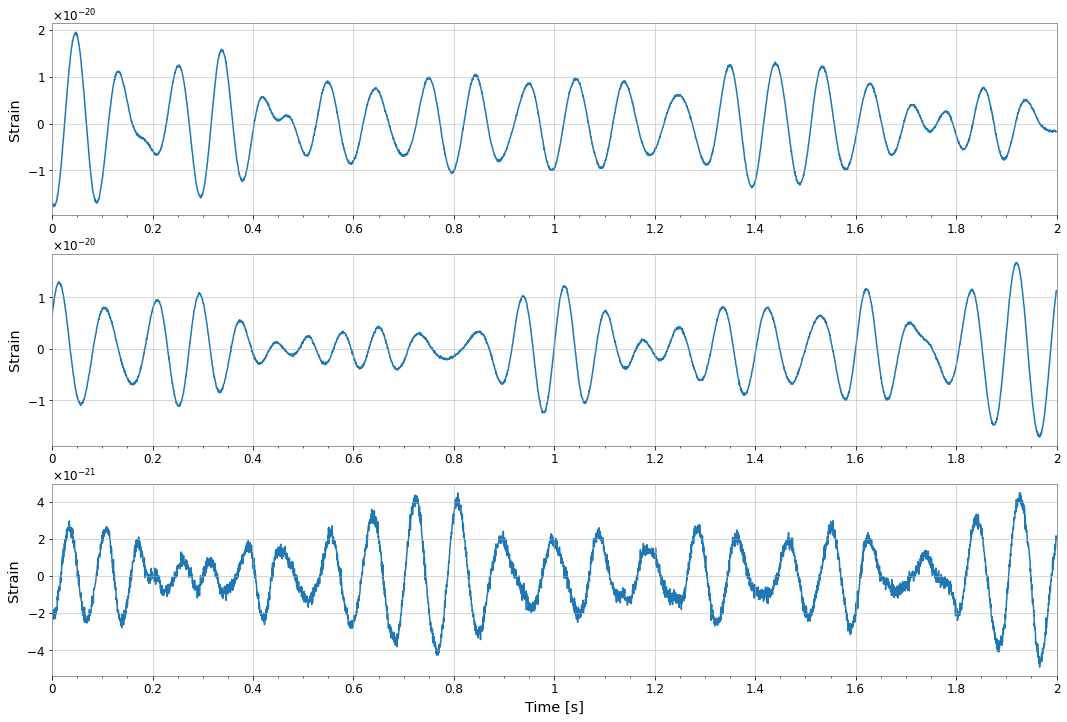

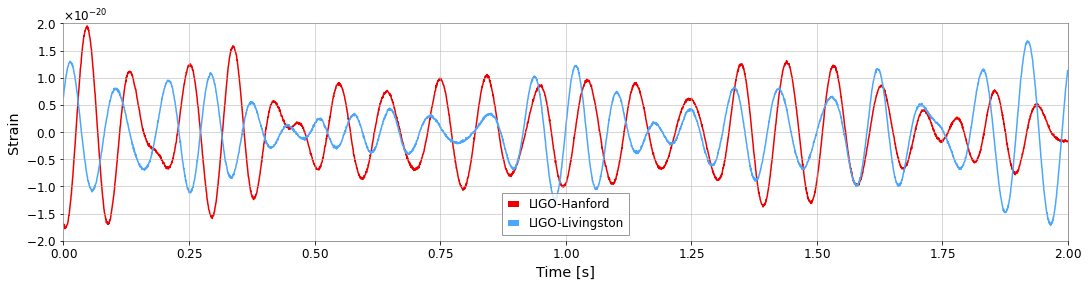

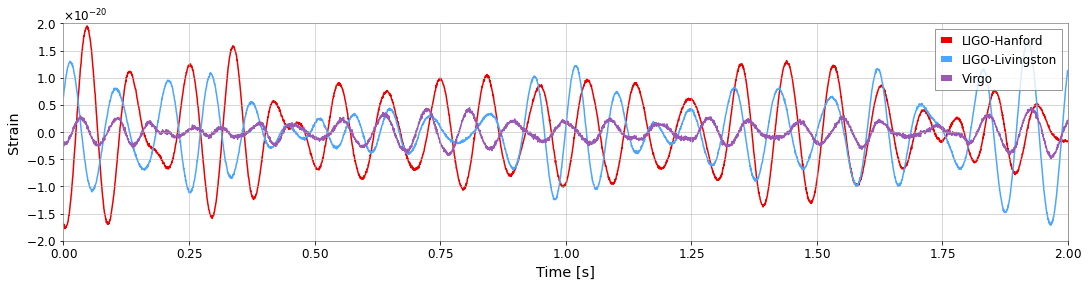

In [7]:
# data sample target 1
file_npy_ev_1 = os.path.join(PATH,path_1)
print( file_npy_ev_1, '\n' )
print( np.load(file_npy_ev_1).shape , '\n')
# plot data sample
Hanford, Livingston, Virgo = get_npy_data(file_npy_ev_1)
plot_time_series(Hanford, Livingston, Virgo)
plot_time_series_LIGO(Hanford, Livingston)
plot_time_series_all(Hanford, Livingston, Virgo)

<a id="subsection-3_2"></a>
### 3.2 Time series example, target=0 : 

../input/g2net-gravitational-wave-detection/train/e/2/6/e263e86fca.npy 

(3, 4096) 



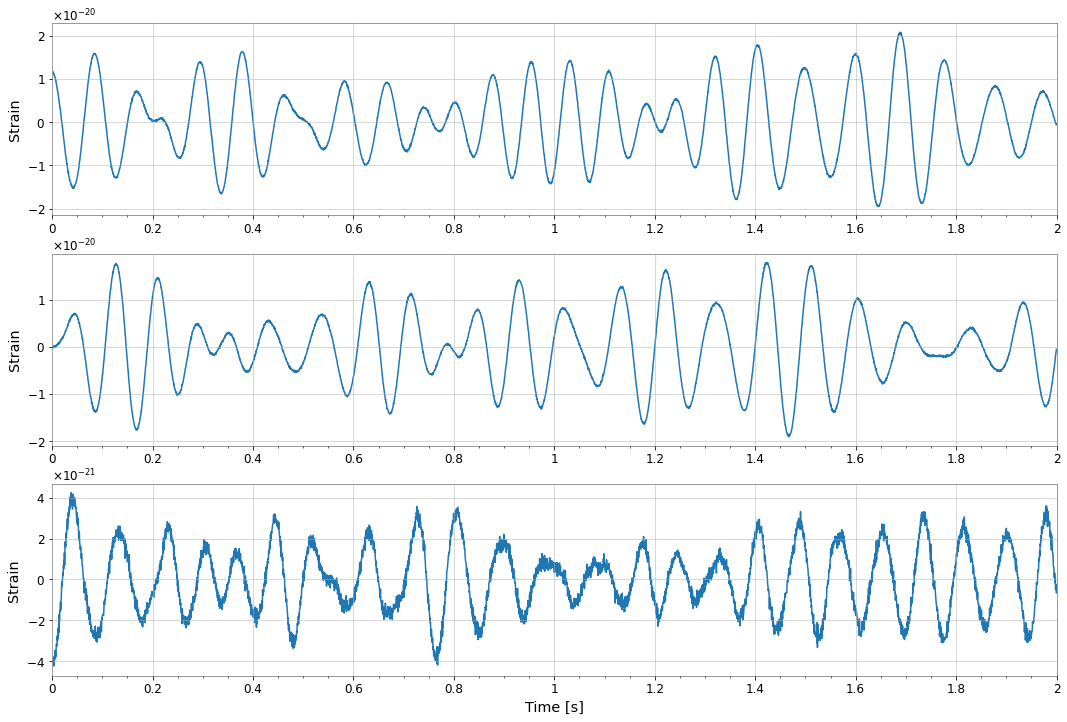

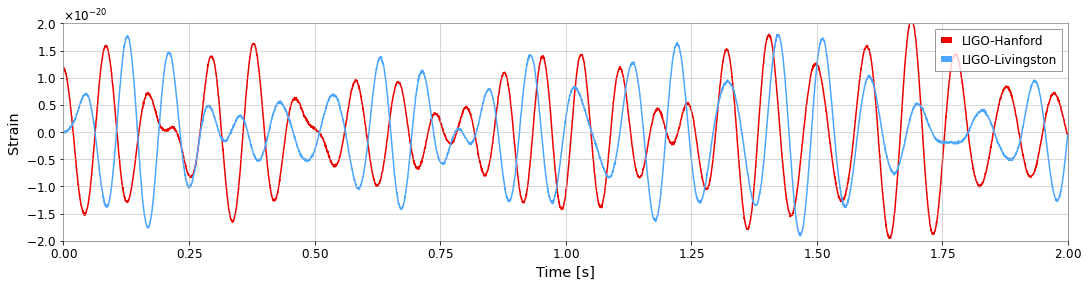

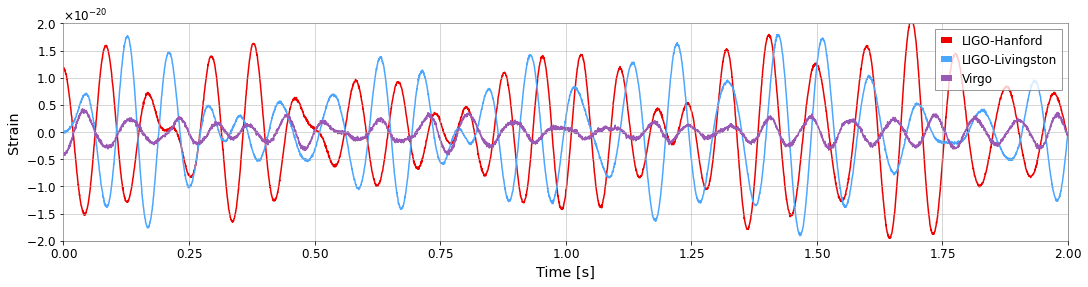

In [8]:
# data sample target 1
file_npy_ev_0 = os.path.join(PATH,path_0)
print( file_npy_ev_0, '\n' )
print( np.load(file_npy_ev_0).shape , '\n')
# plot data sample
Hanford, Livingston, Virgo = get_npy_data(file_npy_ev_0)
plot_time_series(Hanford, Livingston, Virgo)
plot_time_series_LIGO(Hanford, Livingston)
plot_time_series_all(Hanford, Livingston, Virgo)

<a id="section-4"></a>
## 4. Represent training data as spectrograms
A [spectrogram ](https://en.wikipedia.org/wiki/Spectrogram) "is a visual representation of the spectrum of frequencies of a signal as it varies with time". GWpy provides a way to generate a spectrogram from a time series using a [Q-transform or Constant-Q transform](https://en.wikipedia.org/wiki/Constant-Q_transform), which basically "transforms a data series to the frequency domain". This Q-transform is used to "to produce high-resolution time-frequency maps of transient noise (glitches) and potential gravitational-wave signals", [see GWpy documentation on this topic](https://gwpy.github.io/docs/latest/examples/timeseries/qscan.html).

In [9]:
def plot_spectrograms(detector_data, detector_name, event, target, grid):
    """Plot spectrograms for specific detector's event."""
    qspecgram = detector_data.q_transform(outseg=(0.0, 2.0))
    plot = qspecgram.plot(figsize=[6, 4])
    ax = plot.gca()
    ax.set_title('{}. Event: {}. Target: {}'.format(detector_name, event, target))
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [Hz]')
    ax.grid(grid)
    ax.colorbar(cmap='viridis', label='Normalized energy')
    plot.show()

def plot_all_spectrograms(detectors, names, event, target, grid):
    """From a list o data from detectors and a list of 
    their names plots the spectrograms of the three 
    time series, it also requires the event id, known 
    target and an option to add a grid (True/False)"""
    for detector, name in zip(detectors,names):
        plot_spectrograms(detector, name, event, target, grid)

<a id="subsection-4_1"></a>
### 4.1 Spectrogram example, target=1 : 

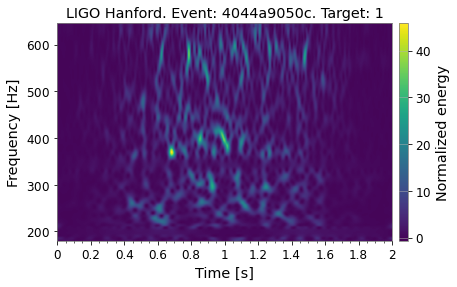

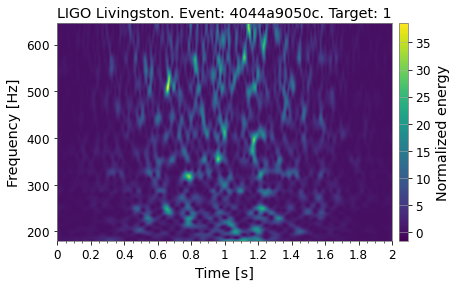

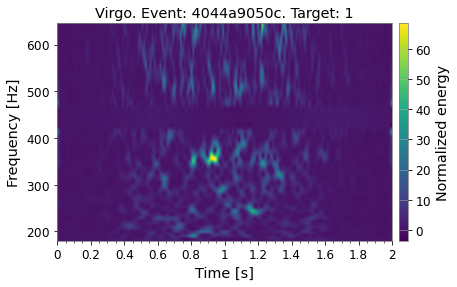

In [10]:
# get the data (same data sample as in the previous section)
Hanford, Livingston, Virgo = get_npy_data(file_npy_ev_1)
interferometers = [Hanford, Livingston, Virgo] 
internames = ['LIGO Hanford', 'LIGO Livingston', 'Virgo']
target_sample = train_labels[train_labels['id'] == event_1]['target'].iloc[0]
# plot the spectrograms
plot_all_spectrograms(detectors=interferometers,names=internames,event=event_1,target=target_sample, grid=False)

<a id="subsection-4_2"></a>
### 4.2 Spectrogram example, target=0 : 

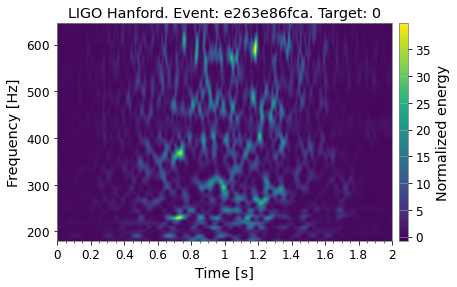

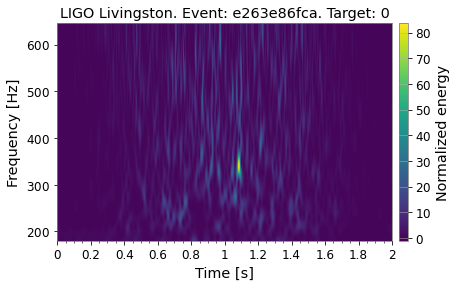

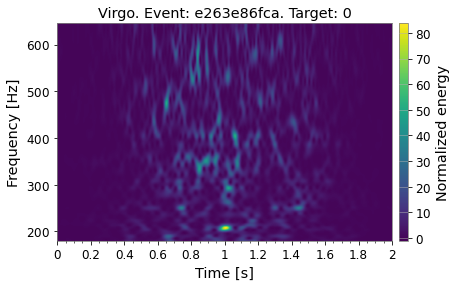

In [11]:
# get the data (same data sample as in the previous section)
Hanford, Livingston, Virgo = get_npy_data(file_npy_ev_0)
interferometers = [Hanford, Livingston, Virgo] 
internames = ['LIGO Hanford', 'LIGO Livingston', 'Virgo']
target_sample = train_labels[train_labels['id'] == event_0]['target'].iloc[0]
# plot the spectrograms
plot_all_spectrograms(detectors=interferometers,names=internames,event=event_0,target=target_sample, grid=False)

<a id="section-5"></a>
## 5. Represent data as power spectral density (PSD)
Power spectral density (PSD) is used to represent [spectral density](https://en.wikipedia.org/wiki/Spectral_density), which "describes the distribution of power into frequency components composing that signal", PSD "refers to the spectral energy distribution that would be found per unit time". GWpy provides a method for [spectral density estimation from a time series called psd()](https://gwpy.github.io/docs/latest/signal/index.html). 


In [12]:
def plot_PSD(detector_data, detector_name, event, target, grid, clr='black'):
    """Plot spectrograms for specific detector's event."""
    PSD = detector_data.psd()
    plot = PSD.plot(figsize=[10, 8], color=clr)
    ax = plot.gca()
    ax.set_title('{}. Event: {}. Target: {}'.format(detector_name, event, target))
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel(r'PSD [strain$/\sqrt{\mathrm{Hz}}$]')
    ax.grid(grid)
    plot.show()

def plot_all_PSD(detectors, names, event, target, grid):
    """From a list o data from detectors and a list of 
    their names plots the spectrograms of the three 
    time series, it also requires the event id, known 
    target and an option to add a grid (True/False)"""
    colors=['red','blue','purple']
    for detector, name, colr in zip(detectors,names,colors):
        plot_PSD(detector, name, event, target, grid, clr=colr)

<a id="subsection-5_1"></a>
### 5.1 PSD example, target=1 : 

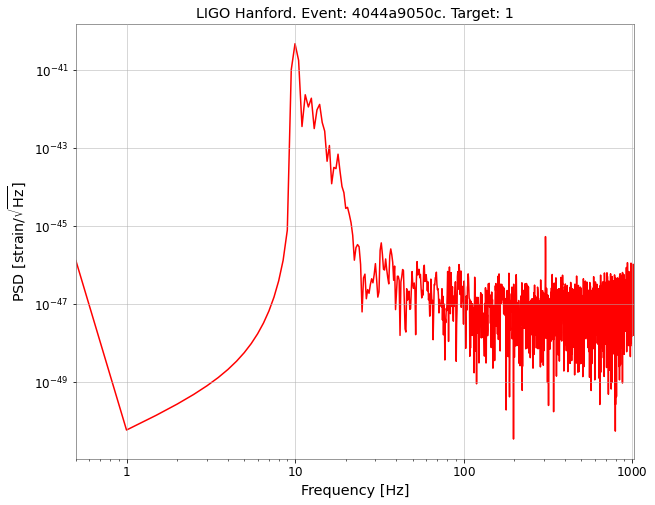

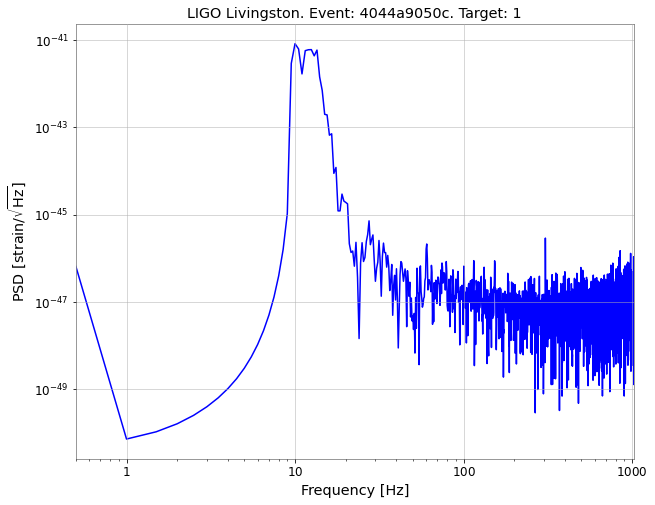

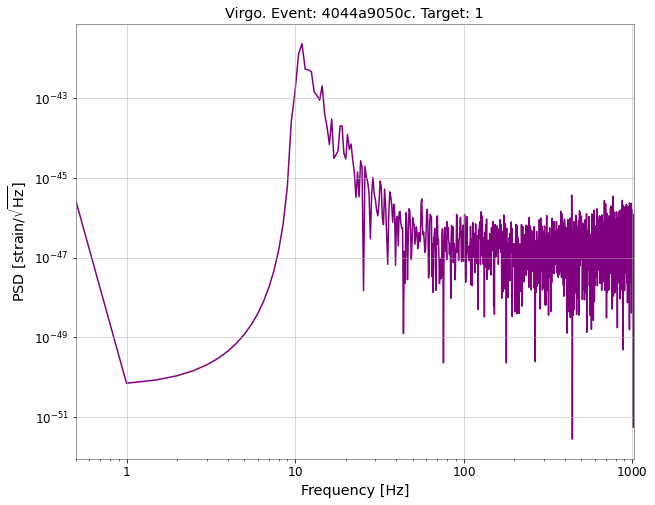

In [13]:
# plot all PSD for the three detectors
Hanford, Livingston, Virgo = get_npy_data(file_npy_ev_1)
interferometers = [Hanford, Livingston, Virgo] 
internames = ['LIGO Hanford', 'LIGO Livingston', 'Virgo']
target_sample = train_labels[train_labels['id'] == event_1]['target'].iloc[0]
plot_all_PSD(detectors=interferometers,names=internames,event=event_1,target=target_sample, grid=True)

<a id="subsection-5_2"></a>
### 5.2 PSD example, target=0 : 

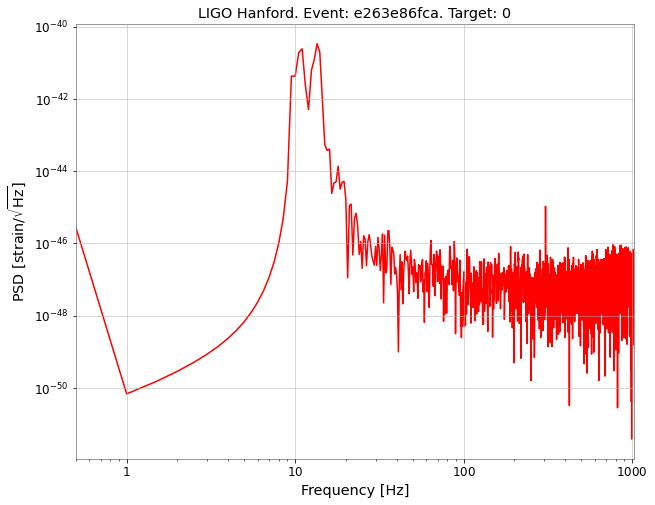

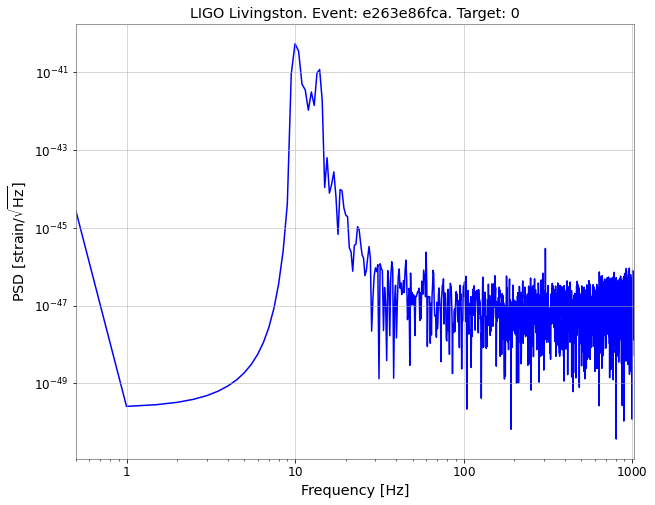

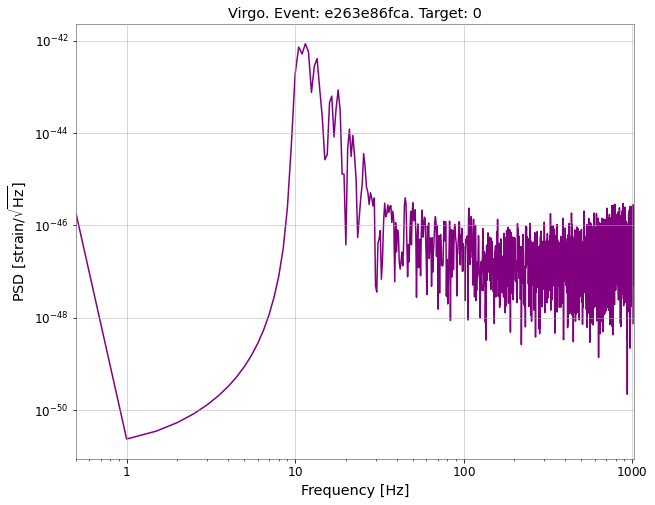

In [14]:
# plot all PSD for the three detectors
Hanford, Livingston, Virgo = get_npy_data(file_npy_ev_0)
interferometers = [Hanford, Livingston, Virgo] 
internames = ['LIGO Hanford', 'LIGO Livingston', 'Virgo']
target_sample = train_labels[train_labels['id'] == event_0]['target'].iloc[0]
plot_all_PSD(detectors=interferometers,names=internames,event=event_0,target=target_sample, grid=True)